In [30]:
import time
import math
import scipy
import scipy.io
import scipy.signal as s
import scipy.integrate as integrate
import scipy.interpolate as interp
import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np

def todB(x): return 10 * np.log10(abs(x))
def amp(x): return 10**(x/10)

def t90(x):
    total = sum(x)
    peak = int(len(x)/2)
    for i in range(1,10000):
        if(sum(x[peak-i:peak+i])>=(0.9*total)):
            return 2*i/fs
    return -99999

    
#   t90(x) gradually increases a symetric window around the peak untill it reaches 90% of the total
#   returns the window size in units of seconds

full = scipy.io.loadmat('23B_121_86_FullGun.mat')
partial = scipy.io.loadmat('23B_123_409_NoGun.mat')

test = scipy.io.loadmat('MGL1212_Line_AT.mat')

f1 = full['Data1']
f2 = full['Data2']

p1 = partial['Data1']
p2 = partial['Data2']

f1=test['Data1']

f1=np.transpose(f1)
f1 = f1*(10**6) #convert to micro pascals
fs = 500

In [31]:
# I. High Pass Filter to remove streamer noise

#Applies 3 biquad filters with 11hz cutoff to remove streamer noise

#sos=[[1,-2,1,1,-1.57883968824571,0.784656386402953],[1,-2,1,1,-1.33067758101229,0.504143999468062],[1,-2,1,1,-1.21996799113476,0.379002366608222]]
b, a = s.butter(4, 2*11/500, 'highpass', analog=True)
w, h = s.freqs(b, a)

#plt.plot(w, 20 * np.log10(abs(h)))
#plt.xscale('log')
#plt.title('Butterworth filter frequency response')
#plt.xlabel('Frequency [radians / second]')
#plt.ylabel('Amplitude [dB]')
#plt.show()
fData = []
for row in f1:
    #fData.append(s.sosfilt(sos,row))
    fData.append(s.filtfilt(b,a,row))
fData=np.asarray(fData)


In [32]:
# II. Adjusting for group length (+6dB)
fData = amp(6)*fData # adjusted filtered data

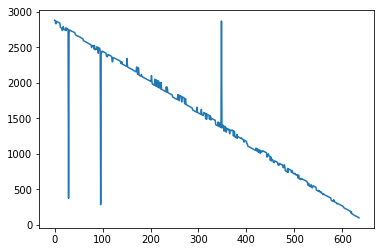

In [43]:
# III. Windowing Around Peak (2s before and after)
peak=[]
#forward 2 s
winData = []#windowed data
for row in fData:
    peak1 = np.argmax(row[0:10*fs])
    DATA = row[peak1-2*fs:peak1+2*fs]#Keep data around the peak
    winData.append(DATA)
    peak.append(peak1)
winData = np.asarray(winData)
plt.plot(peak)
plt.show()

/home/zomege/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


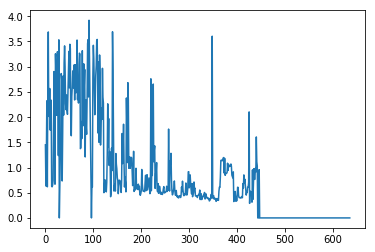

In [44]:
# IV. Calculate RMS Density

squaredPressure = np.multiply(winData,winData)

RMS = []
T90 = []
i = 0

for row in squaredPressure:
    T90a=t90(row)
    RMS.append(10*np.log10(sum(row/fs)/T90a))#integrate squared pressure / T90
    i = i+1
    T90.append(T90a)
RMS = np.asarray(RMS)
#print(RMS)
#print(T90)
plt.plot(T90)
plt.show()

In [35]:
#IV. Calculate SEL Energy Density (dB)

SEL=[]

i = 0
for rms in RMS:
    SEL.append(rms+10*np.log10(T90[i]))# RMS + log(T90)
    i = i+1

print(SEL)

scipy.io.savemat('Data1.mat', mdict={'SEL':SEL,'RMS':RMS,'Windowed': winData,'Filtered':fData,'Original':f1})#debug

[158.75495160538466, 158.32319606571318, 159.58710196674008, 160.35769759871644, 158.39538897076235, 159.66428122742195, 162.14520276084369, 159.94367597515969, 159.77758420441995, 159.89300693523083, 159.6545905204072, 161.07560800338794, 160.01066510585622, 159.0830699423565, 154.35825827487247, 147.44052965536656, 149.37470819430769, 159.04159563131722, 161.11149431570792, 160.9804149855126, 160.31957105786711, 161.54728802733663, 161.43508183951326, 162.20760832267865, 161.61919636902221, 162.06369796217174, 160.22392014059105, 159.36386878247103, 164.04929766522361, -inf, 160.09752426404228, 159.66714262313911, 160.42670800531513, 160.88174879925671, 159.63812360761872, 159.88751475685589, 160.90241170508756, 161.9804935205911, 161.3315709457454, 162.58058888785195, 163.43827291059222, 162.0828171047595, 162.13188975831838, 162.32054956512997, 162.75523805666288, 162.93291017743445, 161.95958571195922, 162.77670396638092, 162.89754889322472, 162.15146217201826, 162.25232588428747,

/home/zomege/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/zomege/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/zomege/.local/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


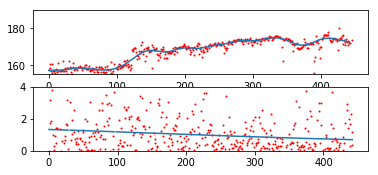

inaccurate: [1, 4, 13, 15, 16, 20, 30, 35, 91, 97, 98, 119, 120, 122, 123, 124, 125, 126, 127, 136, 137, 141, 151, 160, 172, 208, 213, 225, 257, 260, 341, 342, 344, 348, 359, 375, 389, 390, 391, 397, 398, 399, 400, 411, 425, 426] 
noisy: [5, 14, 17, 21, 27, 31, 60, 77, 83, 84, 88, 90, 92, 95, 99, 110, 113, 115, 133, 138, 142, 143, 147, 152, 159, 161, 169, 174, 214, 220, 221, 222, 226, 229, 258, 310, 323, 343, 345, 349, 360, 365, 380, 392, 393, 394, 401, 412, 427, 432, 433, 434, 435, 440]


In [36]:
#V. Remove noisy or inaccurate channels
#RMS Differentials
noisy = []
inaccurate = []#keeps track of indicies
RMS2 = RMS.tolist() #without noisy and inaccurate channels
SEL2 = SEL#.tolist()
RMS_diff = [0]
r1 = 0
for r2 in range(1,636): #Uses relative difference to determine noisy channels
    RMS_diff.append(abs(RMS[r1]-RMS[r2]))
    r1 = r1+1
    
#local regression for RMS and RMS_diff
lowess = sm.nonparametric.lowess
b = np.linspace(0,635,636)
fit = lowess(RMS,b,is_sorted=True,return_sorted=False, frac=0.1)
fitd = lowess(RMS_diff,b,is_sorted=True,return_sorted=False,frac=1)


#Plots
plt.subplot(3,1,1)
plt.plot(b,fit)
plt.scatter(b,RMS,s=1,color='r')
plt.ylim(155,190)
plt.subplot(3,1,2)
plt.plot(b,fitd)
plt.scatter(b,RMS_diff,s=1,color='r')
plt.ylim(0,4)

#Remove bad channels

largeDelta = ((RMS2-fit)**2>=10)#innacurate
largeDelta2 = ((RMS_diff-fitd)**2>=2)#noisy

for i in range(0,636):
    if(largeDelta[i]):
        inaccurate.append(i)
        #RMS2[i]=(RMS2[i-1]+RMS2[i-1])/2
        #SEL2[i]=(SEL2[i-1]+SEL2[i-1])/2
        RMS2[i]=-99999
        SEL2[i]=-99999
    if(largeDelta2[i] and not(largeDelta[i])):
        noisy.append(i)
        #RMS2[i]=(RMS2[i-1]+RMS2[i-1])/2
        #SEL2[i]=(SEL2[i-1]+SEL2[i-1])/2
        RMS2[i]=-99999
        SEL2[i]=-99999

RMS2=[x for x in RMS2 if x != -99999]
SEL2=[x for x in SEL2 if x != -99999]
        
plt.show()
print('inaccurate:',inaccurate,'\nnoisy:',noisy)


SEL180 = -0.0125
SEL160 = -0.0125
RMS180 = -0.0125
RMS160 = -0.0125


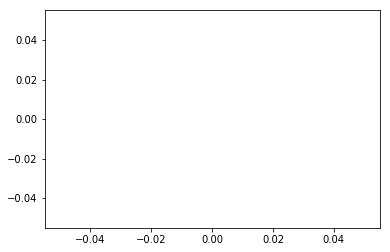

In [37]:
#VI. Fitting Data
b = np.linspace(0,len(RMS2),len(RMS2))

SELmodel = np.polyfit(b, SEL2, deg=8)
RMSmodel = np.polyfit(b, RMS2, deg=8)

SELpol = np.poly1d(SELmodel) 
RMSpol = np.poly1d(RMSmodel)

SEL180 = -1
SEL160 = -1
RMS180 = -1
RMS160 = -1

for i in range(0,360):
    #print(SELpol(i))
    if(SELpol(i)>180):
        SEL180 = i
    if(SELpol(i)>160):
        SEL160 = i
    if(RMSpol(i)>180):
        RMS180 = i
    if(RMSpol(i)>160):
        RMS160 = i
SEL180 = SEL180*(12.5/1000)#converts from index to length in km
SEL160 = SEL160*(12.5/1000)
RMS180 = RMS180*(12.5/1000)
RMS160 = RMS160*(12.5/1000)

print('SEL180 =',SEL180)#Safety radii
print('SEL160 =',SEL160)
print('RMS180 =',RMS180)
print('RMS160 =',RMS160)

plt.plot(b,SELpol(b))
plt.show()